# **Sonuçlar**
- Test seti için ortalama DICE skoru: **0.5815**
- Epoch 30 average loss: **0.4002**

## Problem Tanımı

* 1) **BeyinInmeVerisi.rar** verisini (2383 adet images ve 2382 adet masks) indireceksiniz.
* 2) Veriyi %80 eğitim, %20 test olacak şekilde kodla ayıklayacaksınız.
* 3) Tüm eğitim işlemlerinizi **Epochs = 30** olacak şekilde yapacaksınız.

* 4) Giriş ve çıkış görüntü boyutu 512x512 olacak şekilde ayarlayıp bölütleme modeli eğitilecek. Yani görüntüden herhangi bir patch almadan, bütün olarak girdiyi çıktıya eşleyen bir model **(MODEL1)** eğiteceksiniz.

In [ ]:
# !pip install rarfile -q

# import gdown
# import rarfile
# import os

# # Dosya ID'si ve hedef dosya adı
# file_id = "1JYnUVcI32NpDMjZ3PWMUcJJ6wWaJVw-e"
# output_file = "/content/drive/MyDrive/Colab Notebooks/Biyomedikal/2.Quiz/data/BeyinInmeVerisi.rar"
# extract_folder = "/content/drive/MyDrive/Colab Notebooks/Biyomedikal/2.Quiz/data/BeyinInmeVerisi"

# # Google Drive'dan dosyayı indir
# gdown.download(f"https://drive.google.com/uc?id={file_id}", output_file, quiet=False)

# # RAR dosyasını çıkart
# if not os.path.exists(extract_folder):
#     os.makedirs(extract_folder)

# with rarfile.RarFile(output_file) as rf:
#     rf.extractall(extract_folder)

# print(f"Dosya '{output_file}' indirildi ve '{extract_folder}' klasörüne çıkarıldı.")


### Kütüphaneleri import et

In [ ]:
!pip install monai -q

import logging
import os
import sys
import tempfile
from glob import glob
import numpy as np
import cv2

import torch
from PIL import Image
from torch.utils.tensorboard import SummaryWriter

import monai
from monai.data import ArrayDataset, create_test_image_2d, decollate_batch, DataLoader
from monai.inferers import sliding_window_inference
from monai.metrics import DiceMetric
from monai.transforms import (
    Activations,
    AsDiscrete,
    Compose,
    LoadImage,
    RandRotate90,
    RandSpatialCrop,
    RandSpatialCropSamples,
    Resize,
    ScaleIntensity,
    ToTensor)
from monai.visualize import plot_2d_or_3d_image
import matplotlib.pyplot as plt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 52.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 108.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 78.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 52.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 32.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 16.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 84.2 MB/s eta 0:00:00


### Klasördeki görüntü ve maskeleri tek değişkene bağla

In [ ]:
tempdir = "/content/drive/MyDrive/Colab Notebooks/Biyomedikal/1.Quiz/data/BeyinInmeVerisi-Bolutleme"

images = sorted(glob(os.path.join(tempdir, "images/*.png")))

labels = sorted(glob(os.path.join(tempdir, "masks/*.png")))

In [ ]:
print(len(images), len(labels))

2383 2383


### [Compose](https://docs.monai.io/en/stable/transforms.html): Görüntü üzerinde yapılacak dönüşümleri birleştir

In [ ]:
class LoadPNGImage:
    def __call__(self, img_path):
        image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Tek kanallı yükle
        if image is None:
            raise ValueError(f"Dosya okunamadı: {img_path}")
        image = np.expand_dims(image, axis=0)  # (H, W) → (1, H, W)
        return image.astype(np.float32)


In [ ]:
data_transforms = Compose(
    [
        LoadPNGImage(),
        Resize((512, 512)),
        ScaleIntensity(),
        ToTensor()

    ]
)

post_trans = Compose([Activations(sigmoid=True), AsDiscrete(threshold=0.5)])

###  [Arraydataset](https://docs.monai.io/en/stable/data.html#arraydataset): Klasördeki görüntülerin okunması ve dönüştürülmesi nesnesi:

In [ ]:
ds = ArrayDataset(images, data_transforms, labels, data_transforms)

### [DataLoader](https://https://docs.monai.io/en/stable/modules.html#datasets-and-data-loading): Yüklenen veri nesnesi


In [ ]:
loader = DataLoader(ds, batch_size=8, num_workers=4, pin_memory=torch.cuda.is_available())

### Bazı Batch Boyutlarını İnceleme

In [ ]:
for i, (im, label) in enumerate(loader):
    if i % 5 == 0:  # Only print every 5th batch
        print(f"Batch {i + 1} - Görüntü Boyutu: {im.shape}, Etiket Boyutu: {label.shape}")
    if i >= 10:  # Only process first 10 batches
        break

Batch 1 - Görüntü Boyutu: torch.Size([8, 1, 512, 512]), Etiket Boyutu: torch.Size([8, 1, 512, 512])
Batch 6 - Görüntü Boyutu: torch.Size([8, 1, 512, 512]), Etiket Boyutu: torch.Size([8, 1, 512, 512])
Batch 11 - Görüntü Boyutu: torch.Size([8, 1, 512, 512]), Etiket Boyutu: torch.Size([8, 1, 512, 512])


### Tüm Verinin Toplam Boyutunu Hesaplama

In [ ]:
# Get total size directly from dataset length
total_size = len(loader.dataset)

# Get sample shape from first batch
sample_im, sample_label = next(iter(loader))
im_shape = sample_im.shape[1:]  # Exclude batch dimension
label_shape = sample_label.shape[1:]  # Exclude batch dimension

print(f"Toplam örnek sayısı: {total_size}")
print(f"Görüntü boyutları: {im_shape}")
print(f"Etiket boyutları: {label_shape}")
print(f"Toplam piksel sayısı: {total_size * np.prod(im_shape)} (görüntüler)")
print(f"Toplam piksel sayısı: {total_size * np.prod(label_shape)} (etiketler)")

Toplam örnek sayısı: 2383
Görüntü boyutları: torch.Size([1, 512, 512])
Etiket boyutları: torch.Size([1, 512, 512])
Toplam piksel sayısı: 624689152 (görüntüler)
Toplam piksel sayısı: 624689152 (etiketler)


### İlk görseller

In [ ]:
import matplotlib.pyplot as plt

def goster(goruntuler):
    n = len(goruntuler)  # Görüntü sayısını belirle
    fig, axs = plt.subplots(1, n, figsize=(5*n, 5))

    if n == 1:
        axs = [axs]  # Tek görüntü durumunda listeye çevir

    for i, goruntu in enumerate(goruntuler):
        axs[i].imshow(goruntu, cmap='gray')
        axs[i].axis('off')  # Eksenleri gizle

        # Eğer goruntu bir NumPy array veya PyTorch tensor ise shape kullan
        if hasattr(goruntu, 'shape'):
            height, width = goruntu.shape[:2]
        else:
            width, height = goruntu.size  # PIL Image için

        # Görüntü üzerine boyut bilgisini ekle
        axs[i].text(
            10, 20, f'{width}x{height}', color='white', fontsize=12,
            bbox=dict(facecolor='black', alpha=0.7, edgecolor='none')
        )

    plt.tight_layout()
    plt.show()


torch.Size([8, 1, 512, 512]) torch.Size([8, 1, 512, 512])


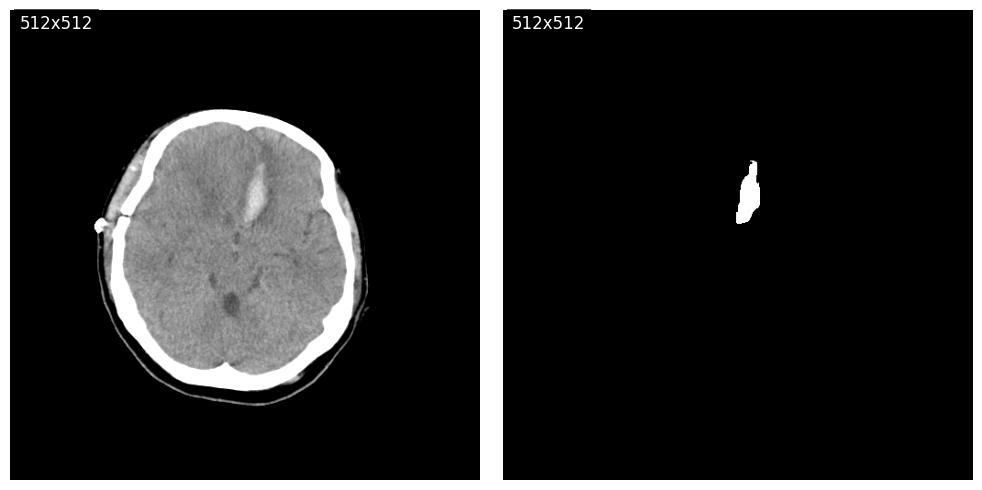

In [ ]:
im, label = monai.utils.misc.first(loader)
print(im.shape, label.shape)
goster([im[0, 0],label[0, 0]])
# B   C  H    W
# 16  1  512  512

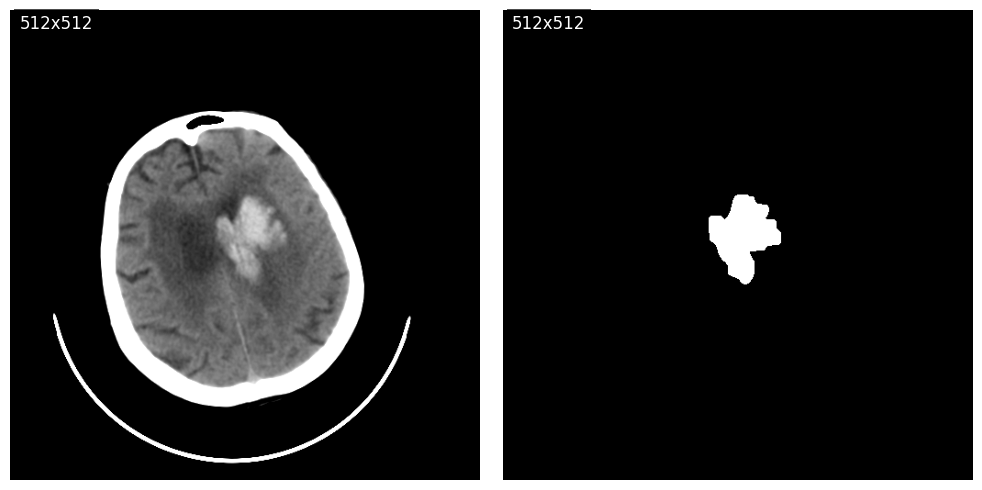

In [ ]:
goster([im[2, 0],label[2, 0]])

### Veri Kümesinin Asıl Boyutunu Görüntüleme

In [ ]:
print(f"Dataset Boyutu (Toplam Örnek Sayisi): {len(loader.dataset)}")

Dataset Boyutu (Toplam Örnek Sayisi): 2383


### Detaylı Boyut Analizi (Loader İçindeki Tüm Veriler)

In [ ]:
# İlk batch'in boyutlarını alın
first_batch_im, first_batch_label = next(iter(loader))

# Boyutlara göre işlemleri yönetin
if len(first_batch_im.shape) == 5:
    B, C, D, H, W = first_batch_im.shape
    print(f"Veri 5D: Batch Boyutu = {B}, Kanal Sayisi = {C}, Derinlik = {D}, Yükseklik = {H}, Genişlik = {W}")
elif len(first_batch_im.shape) == 4:
    B, C, H, W = first_batch_im.shape
    print(f"Veri 4D: Batch Boyutu = {B}, Kanal Sayisi = {C}, Yükseklik = {H}, Genişlik = {W}")
else:
    print(f"Beklenmedik veri boyutu: {first_batch_im.shape}")

Veri 4D: Batch Boyutu = 8, Kanal Sayisi = 1, Yükseklik = 512, Genişlik = 512


In [ ]:
# İlk batch'in boyutlarını alın
first_batch_im, first_batch_label = next(iter(loader))

# Boyutlara göre işlemleri yönetin
if len(first_batch_label.shape) == 5:
    B, C, D, H, W = first_batch_label.shape
    print(f"Veri 5D: Batch Boyutu = {B}, Kanal Sayisi = {C}, Derinlik = {D}, Yükseklik = {H}, Genişlik = {W}")
elif len(first_batch_label.shape) == 4:
    B, C, H, W = first_batch_label.shape
    print(f"Veri 4D: Batch Boyutu = {B}, Kanal Sayisi = {C}, Yükseklik = {H}, Genişlik = {W}")
else:
    print(f"Beklenmedik veri boyutu: {first_batch_label.shape}")

Veri 4D: Batch Boyutu = 8, Kanal Sayisi = 1, Yükseklik = 512, Genişlik = 512


### Eğitim ve test için 80-20 olarak veriyi böl

In [ ]:
# Calculate split indices (80% train, 20% test)
train_size = int(0.9 * len(images))
test_size = len(images) - train_size

# Split the data
train_ds = ArrayDataset(images[:train_size], data_transforms, labels[:train_size], data_transforms)
train_loader = DataLoader(train_ds, batch_size=8, shuffle=True, num_workers=4, pin_memory=torch.cuda.is_available())

test_ds = ArrayDataset(images[train_size:], data_transforms, labels[train_size:], data_transforms)
test_loader = DataLoader(test_ds, batch_size=8, num_workers=4, pin_memory=torch.cuda.is_available())

# Print the split sizes
print(f"Total images: {len(images)}")
print(f"Training set size: {train_size}")
print(f"Test set size: {test_size}")

Total images: 2383
Training set size: 2144
Test set size: 239


### Benzerlik ölçümü için metrik tanımı

In [ ]:
dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)

### Modeli oluştur: UNet, DiceLoss and Adam optimizer

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = monai.networks.nets.UNet(
    spatial_dims=2,
    in_channels=1,
    out_channels=1,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
).to(device)
loss_function = monai.losses.DiceLoss(sigmoid=True)
optimizer = torch.optim.Adam(model.parameters(), 3e-4)

### Eğitime başla

In [ ]:
# Initialize tracking variables
epoch_loss_values = list()
val_metric_values = list()
best_metric = -1
best_metric_epoch = -1
writer = SummaryWriter()

# Import tqdm for progress bar
from tqdm import tqdm

# Training loop
for epoch in range(30):
    print("-" * 40)
    print(f"Epoch {epoch + 1}/{30}")
    model.train()
    epoch_loss = 0
    step = 0

    # Create progress bar for training steps
    epoch_len = len(train_ds) // train_loader.batch_size
    progress_bar = tqdm(train_loader, total=epoch_len, desc=f"Training", unit="batch")

    # Training steps
    for batch_data in progress_bar:
        step += 1
        inputs, labels = batch_data[0].to(device), batch_data[1].to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

        # Update progress bar description with current loss
        progress_bar.set_postfix({"loss": f"{loss.item():.4f}"})

        # Add to tensorboard less frequently
        if step % 10 == 0:
            writer.add_scalar("train_loss", loss.item(), epoch_len * epoch + step)

    # Calculate average loss for epoch
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"Epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    # Validation phase - now runs every epoch
    model.eval()
    with torch.no_grad():
        dice_metric.reset()

        # Create progress bar for validation
        val_progress = tqdm(test_loader, desc=f"Validation", unit="batch")

        for val_data in val_progress:
            val_inputs, val_labels = val_data[0].to(device), val_data[1].to(device)
            val_outputs = model(val_inputs)
            val_outputs = [post_trans(i) for i in decollate_batch(val_outputs)]
            dice_metric(y_pred=val_outputs, y=decollate_batch(val_labels))

        metric = dice_metric.aggregate().item()
        val_metric_values.append(metric)
        dice_metric.reset()

        if metric > best_metric:
            best_metric = metric
            best_metric_epoch = epoch + 1
            torch.save(model.state_dict(), "/content/drive/MyDrive/Colab Notebooks/Biyomedikal/1.Quiz/modeller/model1.pth")
            print(f"✓ Saved new best model with dice metric: {metric:.4f}")

        print(f"Validation Results - Epoch: {epoch + 1}")
        print(f"Mean Dice: {metric:.4f} (Best: {best_metric:.4f} at epoch {best_metric_epoch})")
        writer.add_scalar("val_mean_dice", metric, epoch + 1)

print("-" * 40)
print(f"Training completed!")
print(f"Best mean dice: {best_metric:.4f} at epoch: {best_metric_epoch}")
writer.close()

----------------------------------------
Epoch 1/30


Training: 100%|██████████| 268/268 [00:26<00:00,  9.94batch/s, loss=0.9638]


Epoch 1 average loss: 0.9615


Validation: 100%|██████████| 30/30 [00:02<00:00, 11.60batch/s]


✓ Saved new best model with dice metric: 0.0996
Validation Results - Epoch: 1
Mean Dice: 0.0996 (Best: 0.0996 at epoch 1)
----------------------------------------
Epoch 2/30


Training: 100%|██████████| 268/268 [00:26<00:00, 10.01batch/s, loss=0.9437]


Epoch 2 average loss: 0.9456


Validation: 100%|██████████| 30/30 [00:02<00:00, 12.32batch/s]


✓ Saved new best model with dice metric: 0.1153
Validation Results - Epoch: 2
Mean Dice: 0.1153 (Best: 0.1153 at epoch 2)
----------------------------------------
Epoch 3/30


Training: 100%|██████████| 268/268 [00:26<00:00, 10.25batch/s, loss=0.9406]


Epoch 3 average loss: 0.9320


Validation: 100%|██████████| 30/30 [00:02<00:00, 12.12batch/s]


✓ Saved new best model with dice metric: 0.1272
Validation Results - Epoch: 3
Mean Dice: 0.1272 (Best: 0.1272 at epoch 3)
----------------------------------------
Epoch 4/30


Training: 100%|██████████| 268/268 [00:26<00:00, 10.24batch/s, loss=0.9031]


Epoch 4 average loss: 0.9197


Validation: 100%|██████████| 30/30 [00:02<00:00, 11.98batch/s]


✓ Saved new best model with dice metric: 0.1385
Validation Results - Epoch: 4
Mean Dice: 0.1385 (Best: 0.1385 at epoch 4)
----------------------------------------
Epoch 5/30


Training: 100%|██████████| 268/268 [00:26<00:00, 10.18batch/s, loss=0.9096]


Epoch 5 average loss: 0.9069


Validation: 100%|██████████| 30/30 [00:02<00:00, 12.18batch/s]


✓ Saved new best model with dice metric: 0.1661
Validation Results - Epoch: 5
Mean Dice: 0.1661 (Best: 0.1661 at epoch 5)
----------------------------------------
Epoch 6/30


Training: 100%|██████████| 268/268 [00:26<00:00, 10.23batch/s, loss=0.8787]


Epoch 6 average loss: 0.8789


Validation: 100%|██████████| 30/30 [00:02<00:00, 12.08batch/s]


✓ Saved new best model with dice metric: 0.2438
Validation Results - Epoch: 6
Mean Dice: 0.2438 (Best: 0.2438 at epoch 6)
----------------------------------------
Epoch 7/30


Training: 100%|██████████| 268/268 [00:26<00:00, 10.21batch/s, loss=0.8196]


Epoch 7 average loss: 0.8357


Validation: 100%|██████████| 30/30 [00:02<00:00, 12.11batch/s]


✓ Saved new best model with dice metric: 0.3547
Validation Results - Epoch: 7
Mean Dice: 0.3547 (Best: 0.3547 at epoch 7)
----------------------------------------
Epoch 8/30


Training: 100%|██████████| 268/268 [00:26<00:00, 10.17batch/s, loss=0.7972]


Epoch 8 average loss: 0.7824


Validation: 100%|██████████| 30/30 [00:02<00:00, 12.01batch/s]


✓ Saved new best model with dice metric: 0.3993
Validation Results - Epoch: 8
Mean Dice: 0.3993 (Best: 0.3993 at epoch 8)
----------------------------------------
Epoch 9/30


Training: 100%|██████████| 268/268 [00:26<00:00, 10.21batch/s, loss=0.4634]


Epoch 9 average loss: 0.7265


Validation: 100%|██████████| 30/30 [00:02<00:00, 11.90batch/s]


✓ Saved new best model with dice metric: 0.4456
Validation Results - Epoch: 9
Mean Dice: 0.4456 (Best: 0.4456 at epoch 9)
----------------------------------------
Epoch 10/30


Training: 100%|██████████| 268/268 [00:26<00:00, 10.21batch/s, loss=0.6897]


Epoch 10 average loss: 0.6739


Validation: 100%|██████████| 30/30 [00:02<00:00, 12.21batch/s]


✓ Saved new best model with dice metric: 0.5236
Validation Results - Epoch: 10
Mean Dice: 0.5236 (Best: 0.5236 at epoch 10)
----------------------------------------
Epoch 11/30


Training: 100%|██████████| 268/268 [00:26<00:00, 10.18batch/s, loss=0.6939]


Epoch 11 average loss: 0.6256


Validation: 100%|██████████| 30/30 [00:02<00:00, 12.01batch/s]


Validation Results - Epoch: 11
Mean Dice: 0.4290 (Best: 0.5236 at epoch 10)
----------------------------------------
Epoch 12/30


Training: 100%|██████████| 268/268 [00:26<00:00, 10.21batch/s, loss=0.6486]


Epoch 12 average loss: 0.5827


Validation: 100%|██████████| 30/30 [00:02<00:00, 12.02batch/s]


Validation Results - Epoch: 12
Mean Dice: 0.4968 (Best: 0.5236 at epoch 10)
----------------------------------------
Epoch 13/30


Training: 100%|██████████| 268/268 [00:26<00:00, 10.21batch/s, loss=0.6372]


Epoch 13 average loss: 0.5534


Validation: 100%|██████████| 30/30 [00:02<00:00, 11.92batch/s]


Validation Results - Epoch: 13
Mean Dice: 0.5235 (Best: 0.5236 at epoch 10)
----------------------------------------
Epoch 14/30


Training: 100%|██████████| 268/268 [00:26<00:00, 10.18batch/s, loss=0.3503]


Epoch 14 average loss: 0.5094


Validation: 100%|██████████| 30/30 [00:02<00:00, 11.55batch/s]


✓ Saved new best model with dice metric: 0.5644
Validation Results - Epoch: 14
Mean Dice: 0.5644 (Best: 0.5644 at epoch 14)
----------------------------------------
Epoch 15/30


Training: 100%|██████████| 268/268 [00:26<00:00, 10.19batch/s, loss=0.5382]


Epoch 15 average loss: 0.4862


Validation: 100%|██████████| 30/30 [00:02<00:00, 11.90batch/s]


✓ Saved new best model with dice metric: 0.5654
Validation Results - Epoch: 15
Mean Dice: 0.5654 (Best: 0.5654 at epoch 15)
----------------------------------------
Epoch 16/30


Training: 100%|██████████| 268/268 [00:26<00:00, 10.20batch/s, loss=0.3150]


Epoch 16 average loss: 0.4468


Validation: 100%|██████████| 30/30 [00:02<00:00, 11.78batch/s]


✓ Saved new best model with dice metric: 0.5875
Validation Results - Epoch: 16
Mean Dice: 0.5875 (Best: 0.5875 at epoch 16)
----------------------------------------
Epoch 17/30


Training: 100%|██████████| 268/268 [00:26<00:00, 10.21batch/s, loss=0.5529]


Epoch 17 average loss: 0.4288


Validation: 100%|██████████| 30/30 [00:02<00:00, 11.64batch/s]


✓ Saved new best model with dice metric: 0.6044
Validation Results - Epoch: 17
Mean Dice: 0.6044 (Best: 0.6044 at epoch 17)
----------------------------------------
Epoch 18/30


Training: 100%|██████████| 268/268 [00:26<00:00, 10.19batch/s, loss=0.3375]


Epoch 18 average loss: 0.4093


Validation: 100%|██████████| 30/30 [00:02<00:00, 12.19batch/s]


Validation Results - Epoch: 18
Mean Dice: 0.5889 (Best: 0.6044 at epoch 17)
----------------------------------------
Epoch 19/30


Training: 100%|██████████| 268/268 [00:26<00:00, 10.19batch/s, loss=0.3282]


Epoch 19 average loss: 0.3882


Validation: 100%|██████████| 30/30 [00:02<00:00, 12.13batch/s]


✓ Saved new best model with dice metric: 0.6095
Validation Results - Epoch: 19
Mean Dice: 0.6095 (Best: 0.6095 at epoch 19)
----------------------------------------
Epoch 20/30


Training: 100%|██████████| 268/268 [00:26<00:00, 10.22batch/s, loss=0.4871]


Epoch 20 average loss: 0.3650


Validation: 100%|██████████| 30/30 [00:02<00:00, 11.33batch/s]


✓ Saved new best model with dice metric: 0.6181
Validation Results - Epoch: 20
Mean Dice: 0.6181 (Best: 0.6181 at epoch 20)
----------------------------------------
Epoch 21/30


Training: 100%|██████████| 268/268 [00:26<00:00, 10.20batch/s, loss=0.3759]


Epoch 21 average loss: 0.3525


Validation: 100%|██████████| 30/30 [00:02<00:00, 12.24batch/s]


Validation Results - Epoch: 21
Mean Dice: 0.6110 (Best: 0.6181 at epoch 20)
----------------------------------------
Epoch 22/30


Training: 100%|██████████| 268/268 [00:26<00:00, 10.20batch/s, loss=0.4252]


Epoch 22 average loss: 0.3342


Validation: 100%|██████████| 30/30 [00:02<00:00, 12.05batch/s]


Validation Results - Epoch: 22
Mean Dice: 0.6104 (Best: 0.6181 at epoch 20)
----------------------------------------
Epoch 23/30


Training: 100%|██████████| 268/268 [00:26<00:00, 10.23batch/s, loss=0.3853]


Epoch 23 average loss: 0.3242


Validation: 100%|██████████| 30/30 [00:02<00:00, 11.82batch/s]


✓ Saved new best model with dice metric: 0.6266
Validation Results - Epoch: 23
Mean Dice: 0.6266 (Best: 0.6266 at epoch 23)
----------------------------------------
Epoch 24/30


Training: 100%|██████████| 268/268 [00:26<00:00, 10.20batch/s, loss=0.3558]


Epoch 24 average loss: 0.3218


Validation: 100%|██████████| 30/30 [00:02<00:00, 12.13batch/s]


Validation Results - Epoch: 24
Mean Dice: 0.6147 (Best: 0.6266 at epoch 23)
----------------------------------------
Epoch 25/30


Training: 100%|██████████| 268/268 [00:26<00:00, 10.20batch/s, loss=0.3254]


Epoch 25 average loss: 0.2947


Validation: 100%|██████████| 30/30 [00:02<00:00, 12.18batch/s]


✓ Saved new best model with dice metric: 0.6311
Validation Results - Epoch: 25
Mean Dice: 0.6311 (Best: 0.6311 at epoch 25)
----------------------------------------
Epoch 26/30


Training: 100%|██████████| 268/268 [00:26<00:00, 10.21batch/s, loss=0.2690]


Epoch 26 average loss: 0.2810


Validation: 100%|██████████| 30/30 [00:02<00:00, 11.70batch/s]


Validation Results - Epoch: 26
Mean Dice: 0.6187 (Best: 0.6311 at epoch 25)
----------------------------------------
Epoch 27/30


Training: 100%|██████████| 268/268 [00:26<00:00, 10.19batch/s, loss=0.2292]


Epoch 27 average loss: 0.2808


Validation: 100%|██████████| 30/30 [00:02<00:00, 12.31batch/s]


✓ Saved new best model with dice metric: 0.6324
Validation Results - Epoch: 27
Mean Dice: 0.6324 (Best: 0.6324 at epoch 27)
----------------------------------------
Epoch 28/30


Training: 100%|██████████| 268/268 [00:26<00:00, 10.20batch/s, loss=0.2734]


Epoch 28 average loss: 0.2607


Validation: 100%|██████████| 30/30 [00:02<00:00, 12.14batch/s]


✓ Saved new best model with dice metric: 0.6361
Validation Results - Epoch: 28
Mean Dice: 0.6361 (Best: 0.6361 at epoch 28)
----------------------------------------
Epoch 29/30


Training: 100%|██████████| 268/268 [00:26<00:00, 10.19batch/s, loss=0.3166]


Epoch 29 average loss: 0.2577


Validation: 100%|██████████| 30/30 [00:02<00:00, 12.16batch/s]


✓ Saved new best model with dice metric: 0.6402
Validation Results - Epoch: 29
Mean Dice: 0.6402 (Best: 0.6402 at epoch 29)
----------------------------------------
Epoch 30/30


Training: 100%|██████████| 268/268 [00:26<00:00, 10.17batch/s, loss=0.2155]


Epoch 30 average loss: 0.2471


Validation: 100%|██████████| 30/30 [00:02<00:00, 12.41batch/s]

✓ Saved new best model with dice metric: 0.6580
Validation Results - Epoch: 30
Mean Dice: 0.6580 (Best: 0.6580 at epoch 30)
----------------------------------------
Training completed!
Best mean dice: 0.6580 at epoch: 30


### Modeli kaydet

In [ ]:
torch.save(model.state_dict(), "/content/drive/MyDrive/Colab Notebooks/Biyomedikal/2.Quiz/model_son.pth")

### DICE metriğini hesaplama

In [ ]:
model.load_state_dict(torch.load("/content/drive/MyDrive/Colab Notebooks/Biyomedikal/1.Quiz/segmentation_model.pth", map_location=device))
print("Model loaded successfully!")

<ipython-input-12-7c48102e9fd4>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/content/drive/MyDrive/Colab Notebooks/Biyomedikal/1.Quiz/

Model loaded successfully!


In [ ]:
dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)

model.eval()  # Modeli değerlendirme moduna al
dice_metric.reset()  # Önceki değerleri sıfırla

with torch.no_grad():  # Gradient hesaplamayı kapat
    for test_data in test_loader:
        test_inputs, test_labels = test_data[0].to(device), test_data[1].to(device)

        test_outputs = model(test_inputs)  # Model tahmini yap
        test_outputs = [post_trans(i) for i in decollate_batch(test_outputs)]  # Post-processing uygula

        dice_metric(y_pred=test_outputs, y=decollate_batch(test_labels))  # DICE metriğini hesapla

# **Ortalama DICE Skorunu Al**
mean_dice = dice_metric.aggregate().item()
dice_metric.reset()  # Metriği sıfırla

print(f"Test seti için ortalama DICE skoru: {mean_dice:.4f}")


Test seti için ortalama DICE skoru: 0.6580


### Test çıktısını al

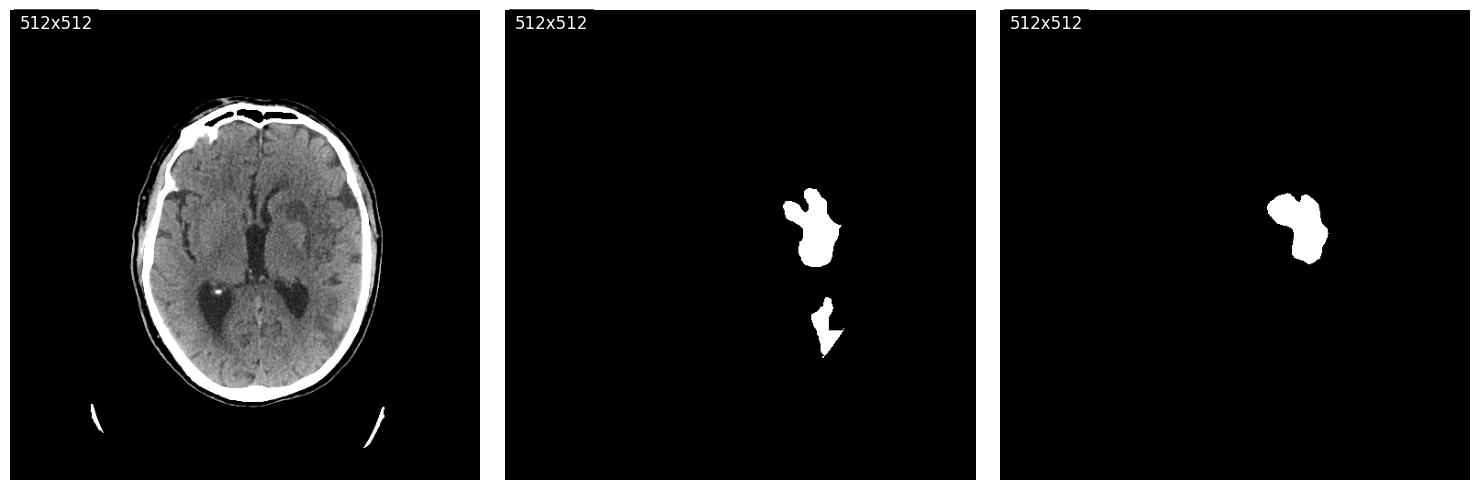

test_images boyutlari: torch.Size([8, 1, 512, 512])
test_outputs1 boyutlari: torch.Size([8, 1, 512, 512])


In [ ]:
# Set window size to 512x512 for full image processing
roi_size = (512, 512)
sw_batch_size = 4

# Test the model with one sample
model.eval()
with torch.no_grad():
    for test_data in test_loader:
        test_images, test_labels = test_data[0].to(device), test_data[1].to(device)
        test_outputs1 = sliding_window_inference(test_images, roi_size, sw_batch_size, model)
        test_outputs2 = [post_trans(i) for i in decollate_batch(test_outputs1)]
        goster([test_images[0][0].cpu().detach().numpy(),
                test_labels[0][0].cpu().detach().numpy(),
                test_outputs2[0][0].cpu().detach().numpy()])

        print(f"test_images boyutlari: {test_images.shape}")
        print(f"test_outputs1 boyutlari: {test_outputs1.shape}")
        break

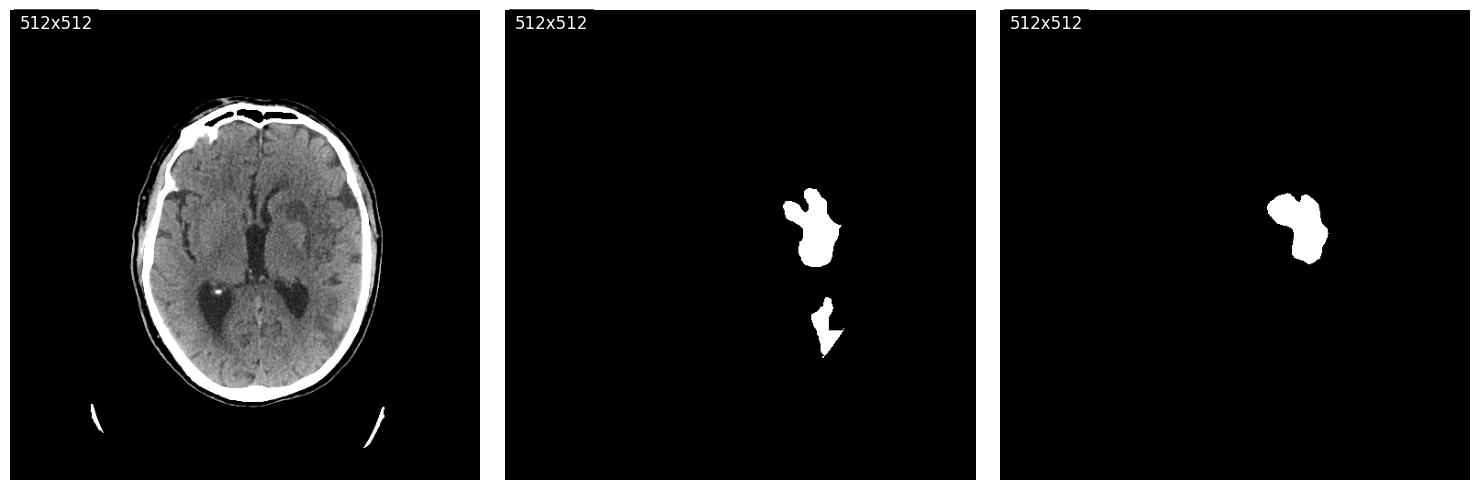

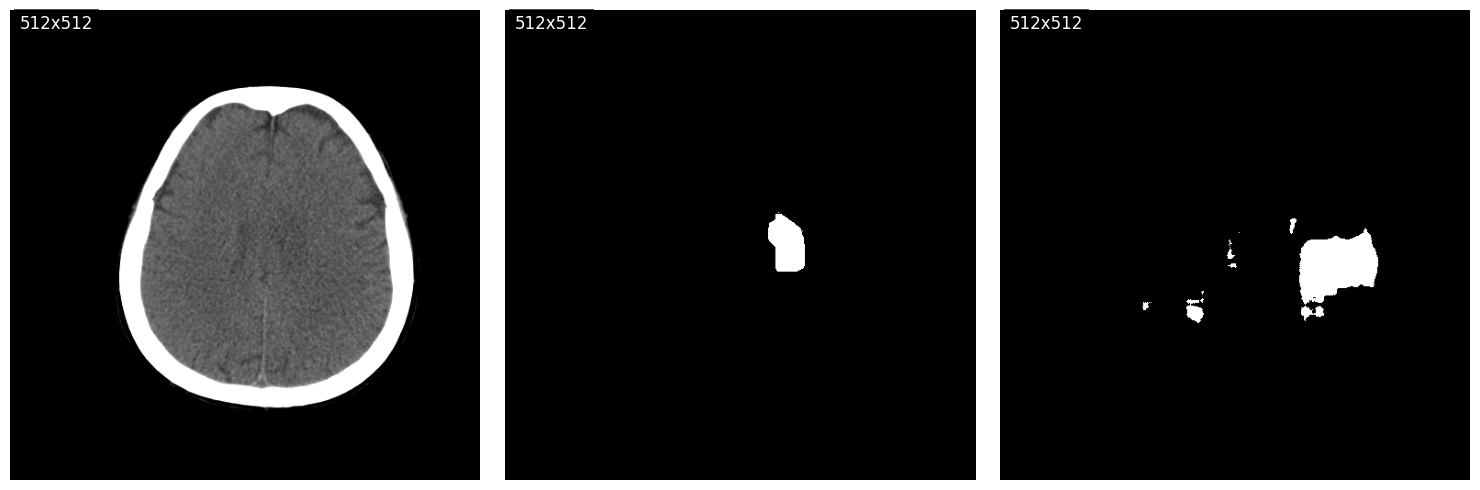

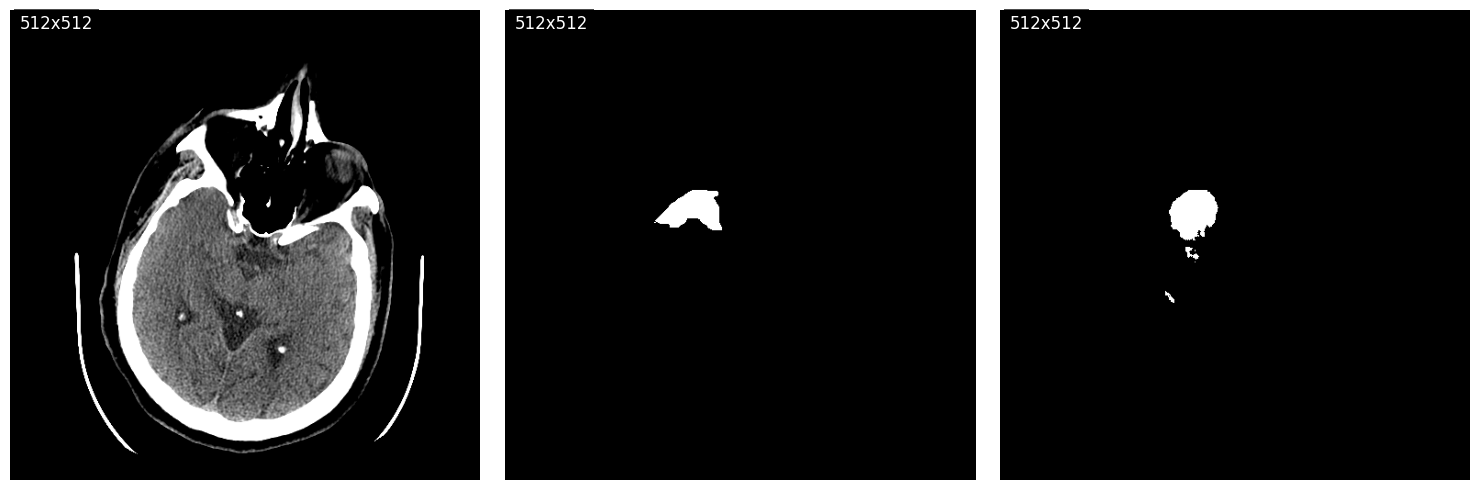

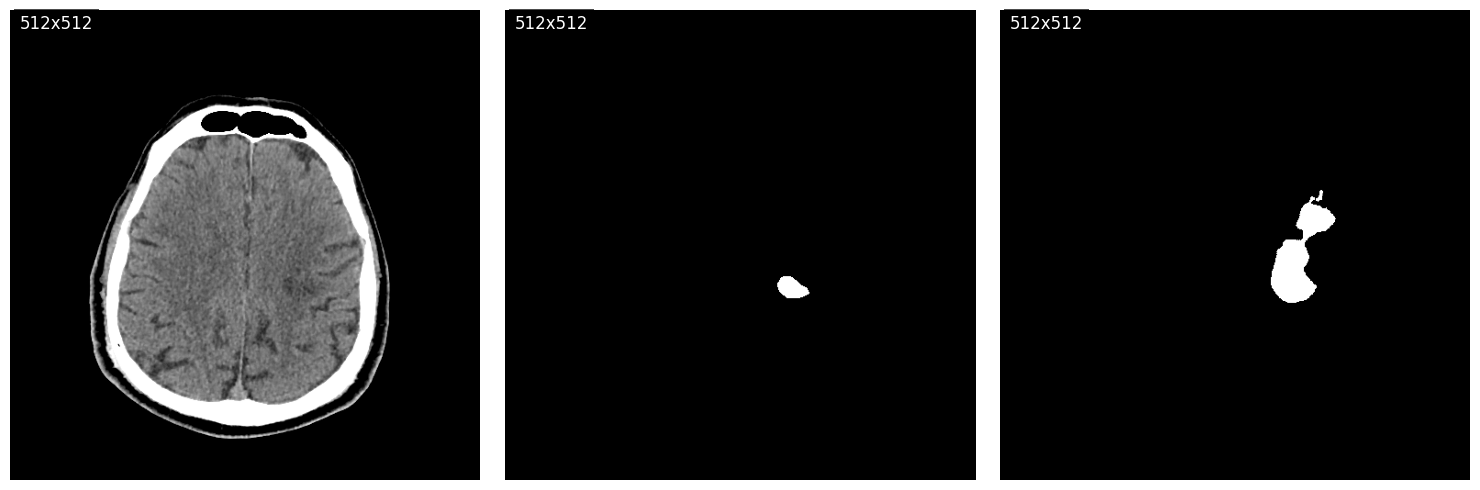

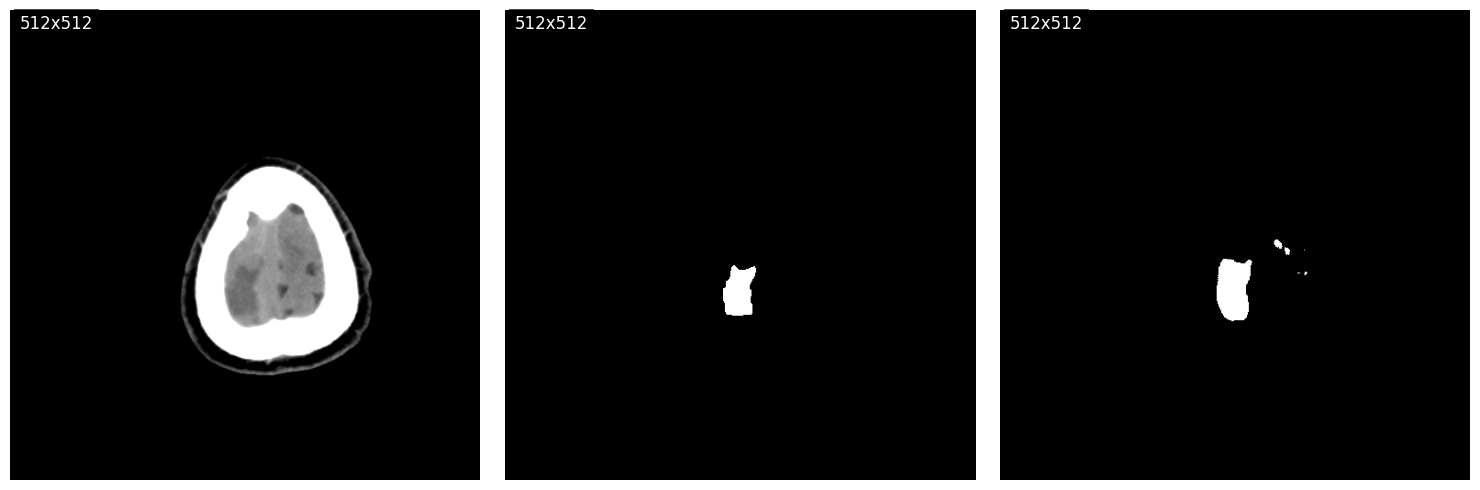

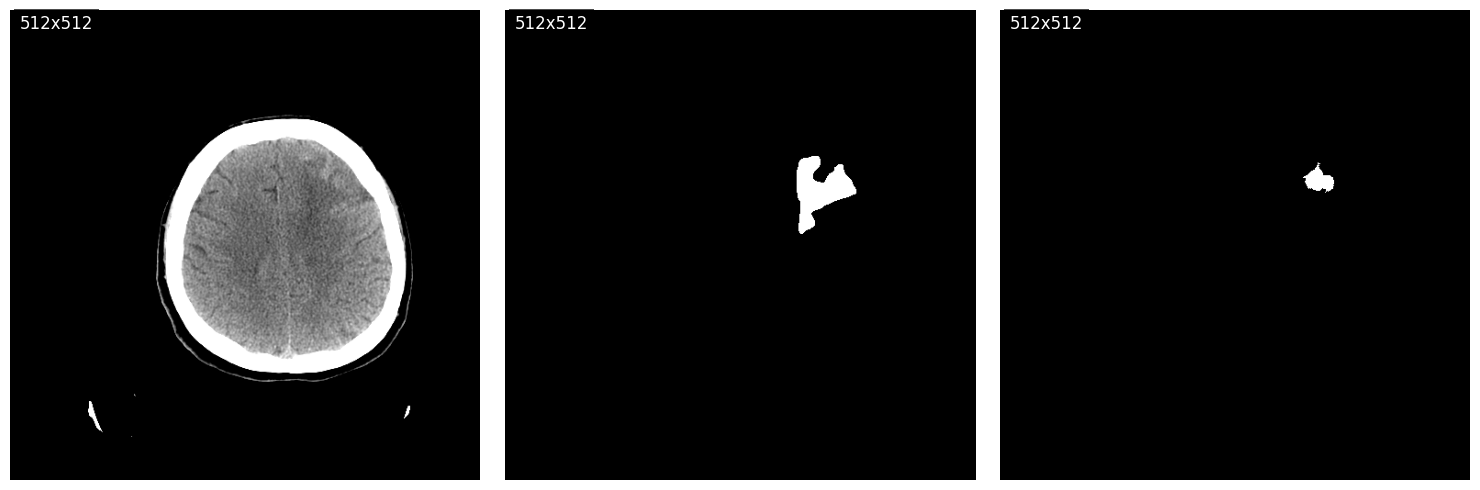

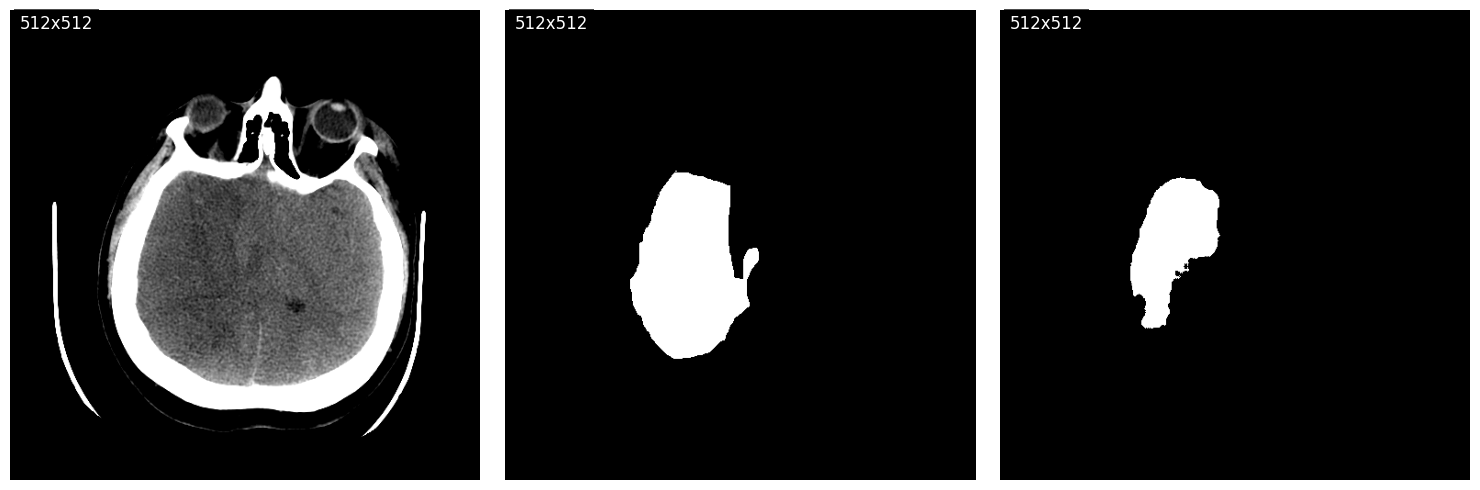

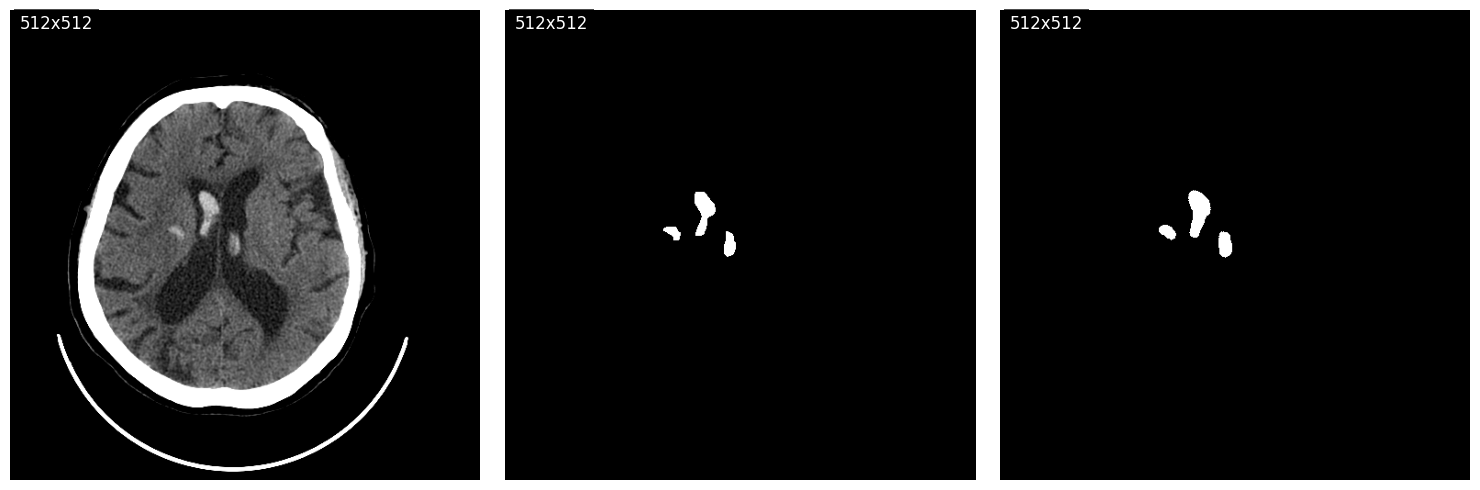

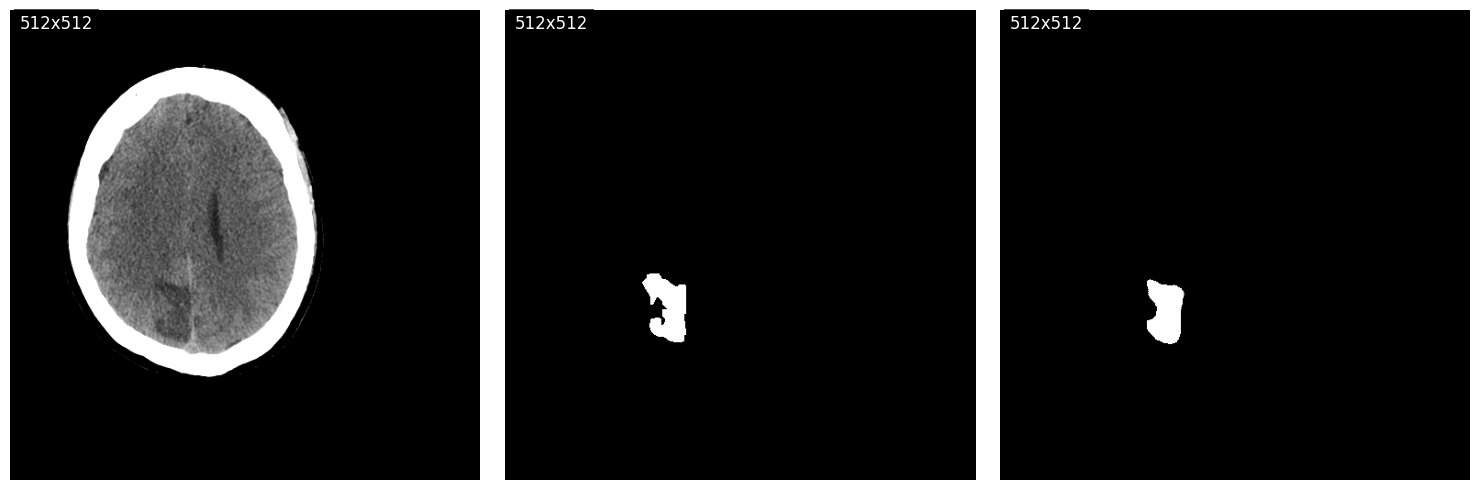

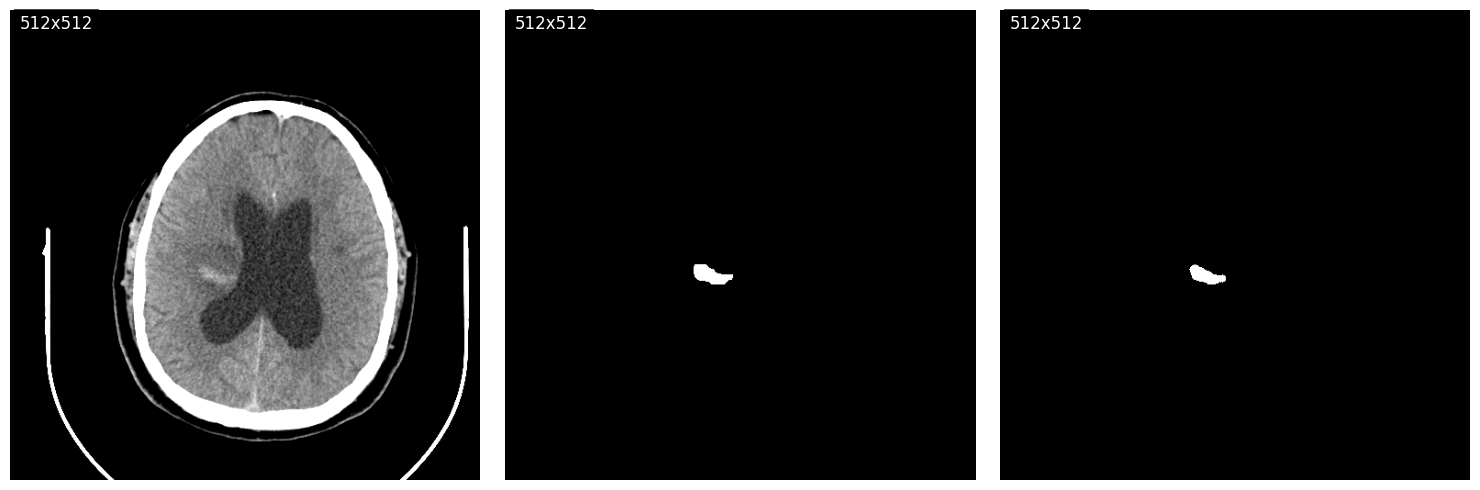

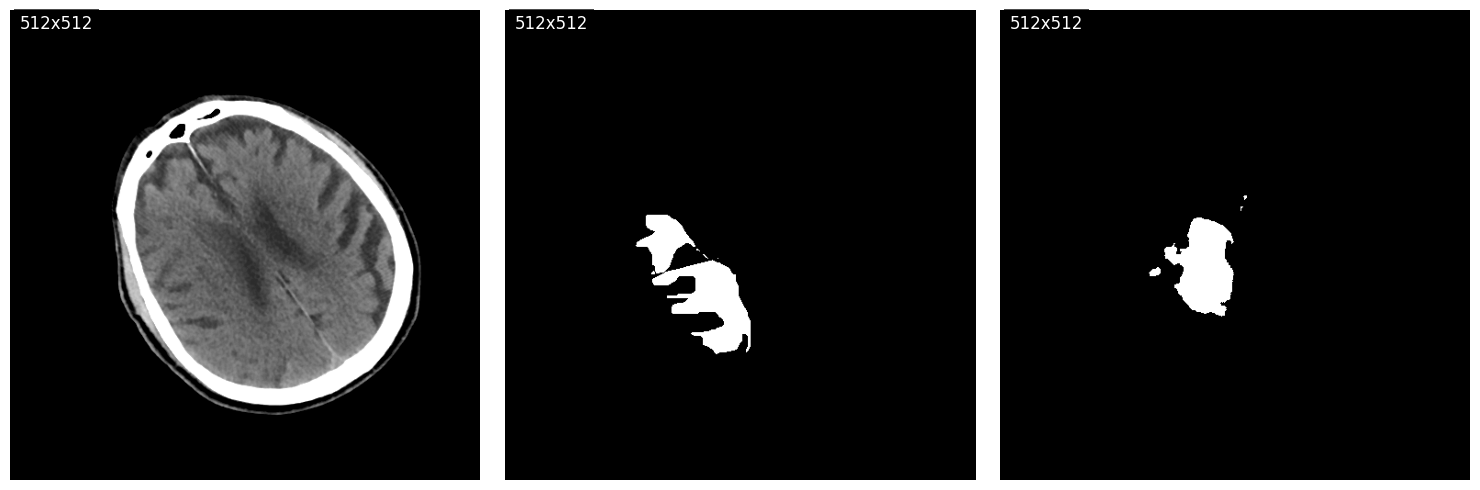

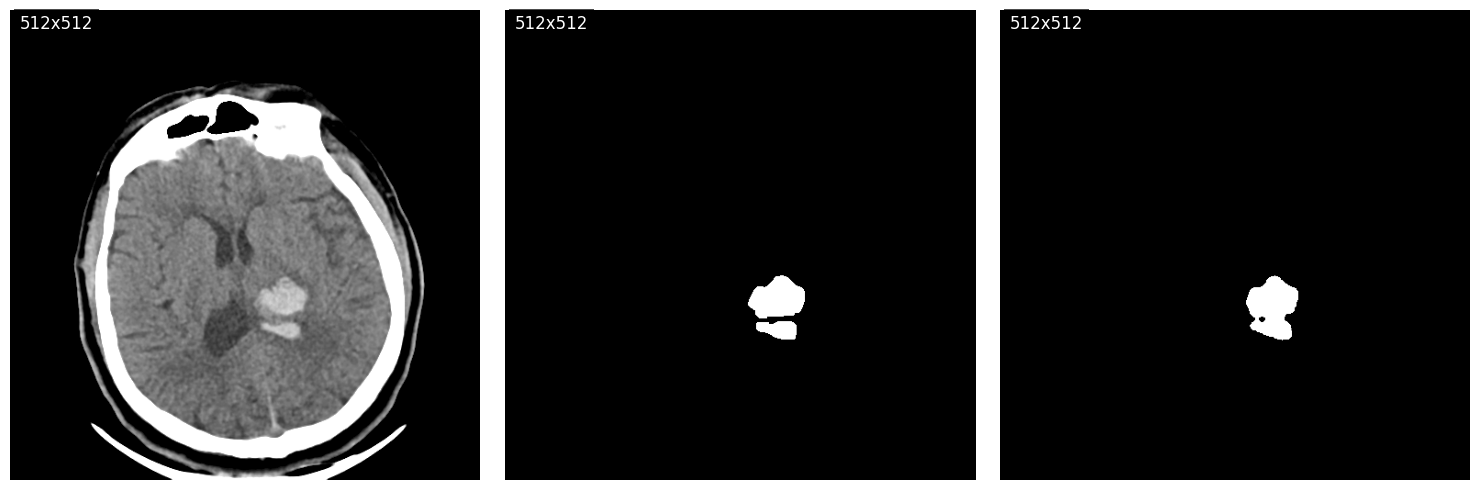

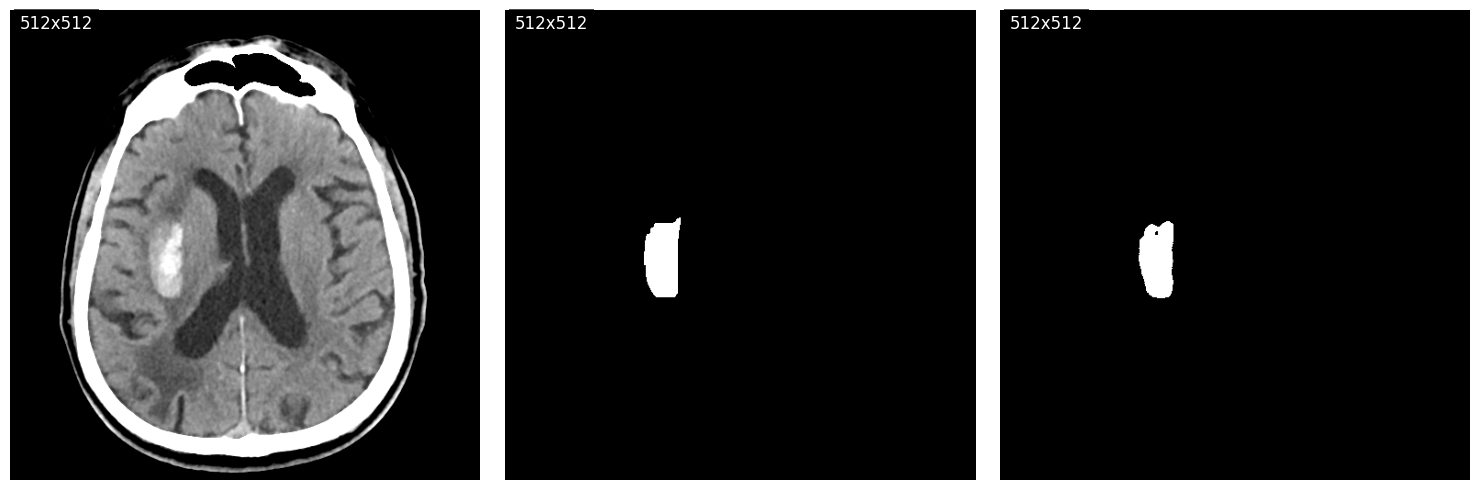

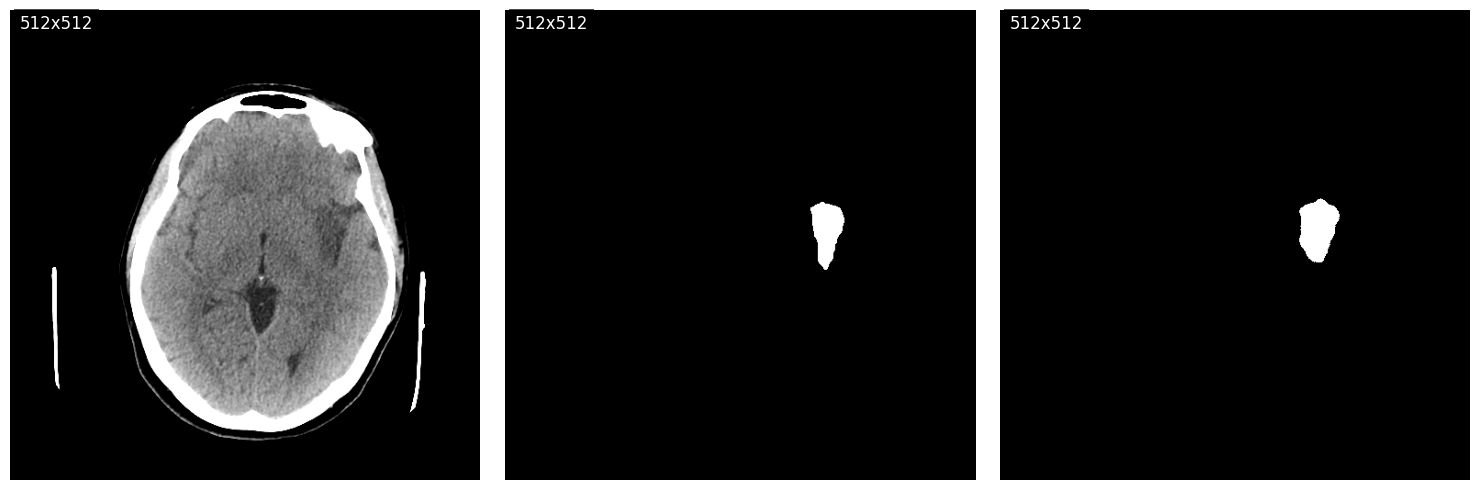

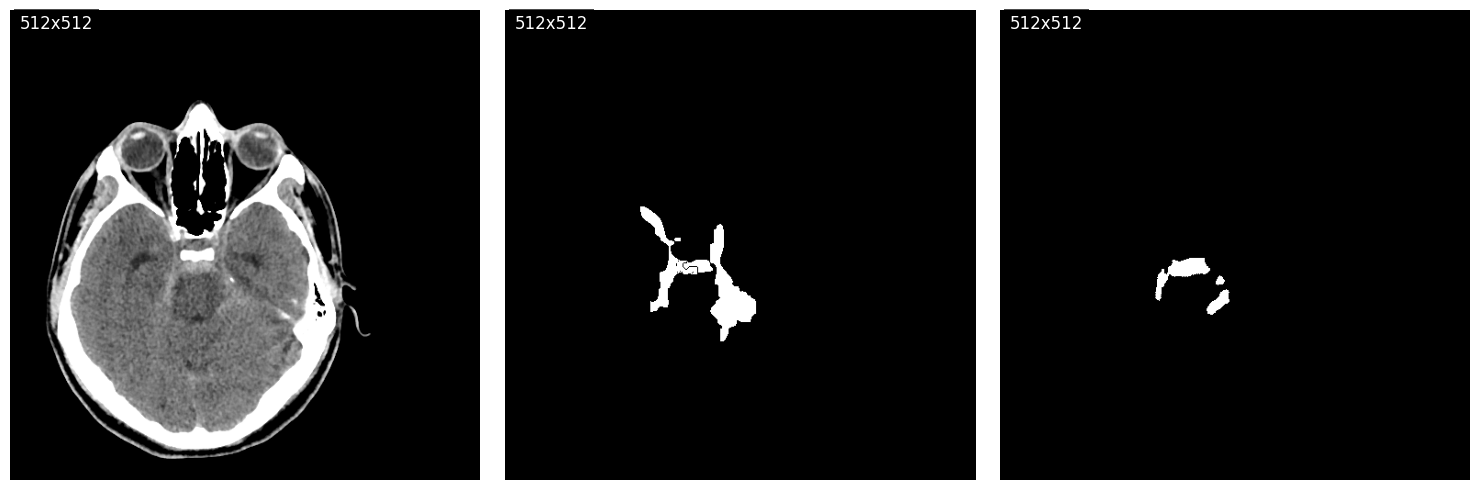

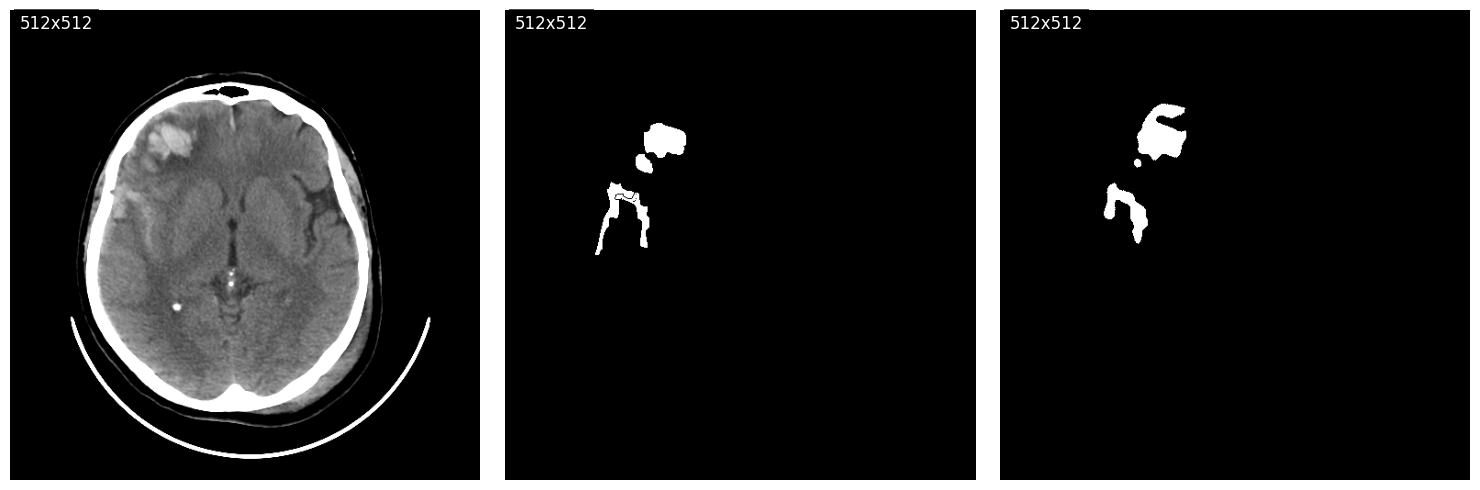

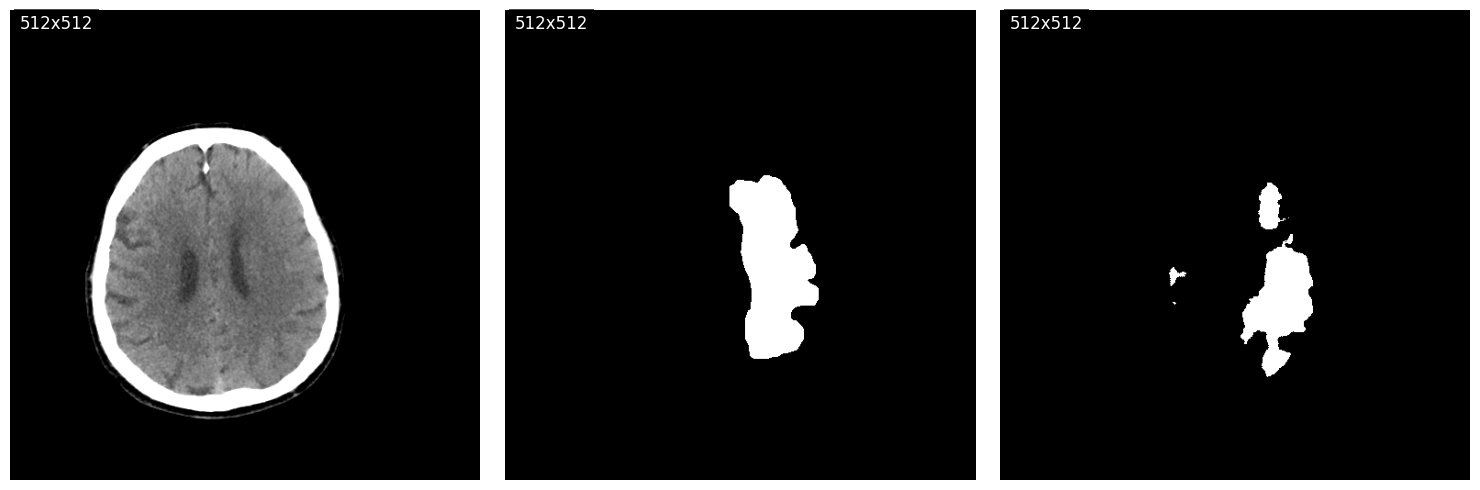

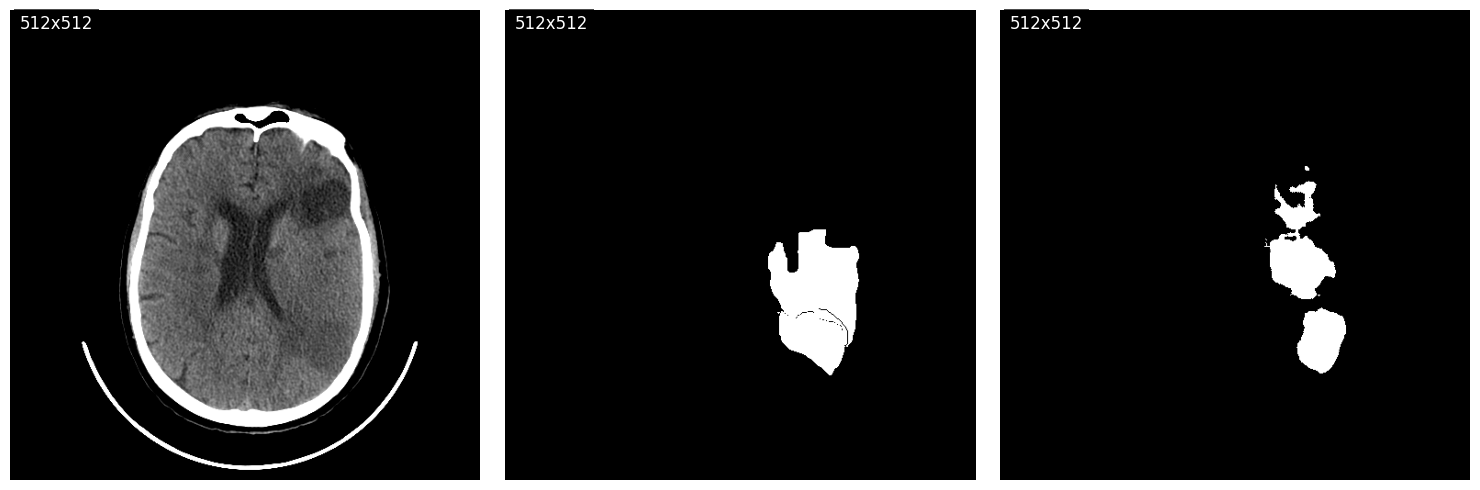

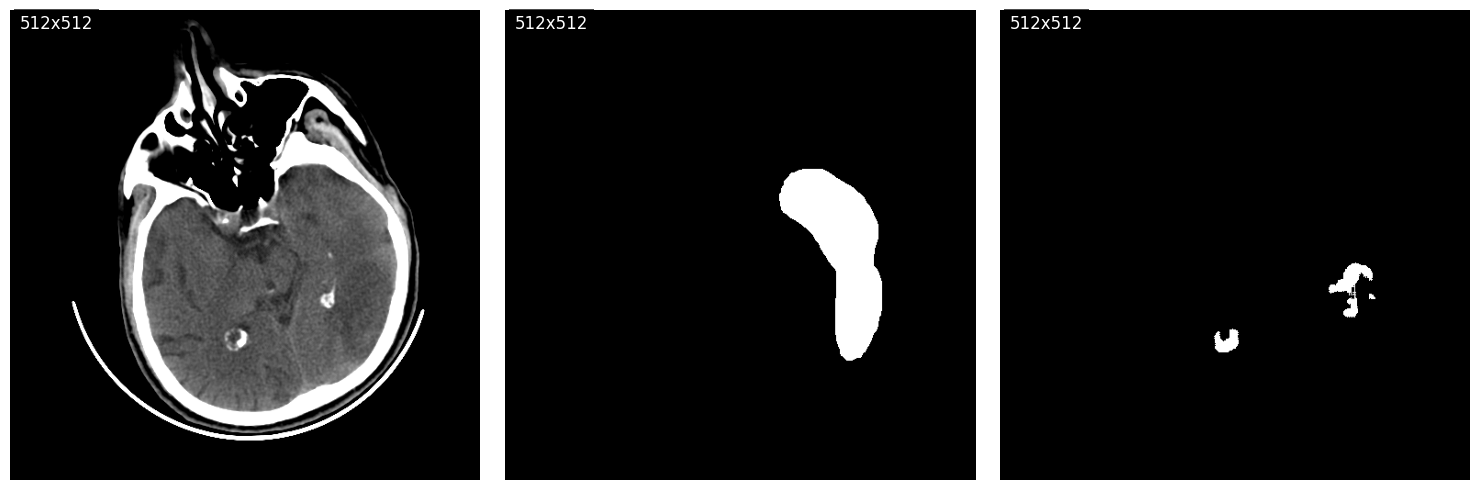

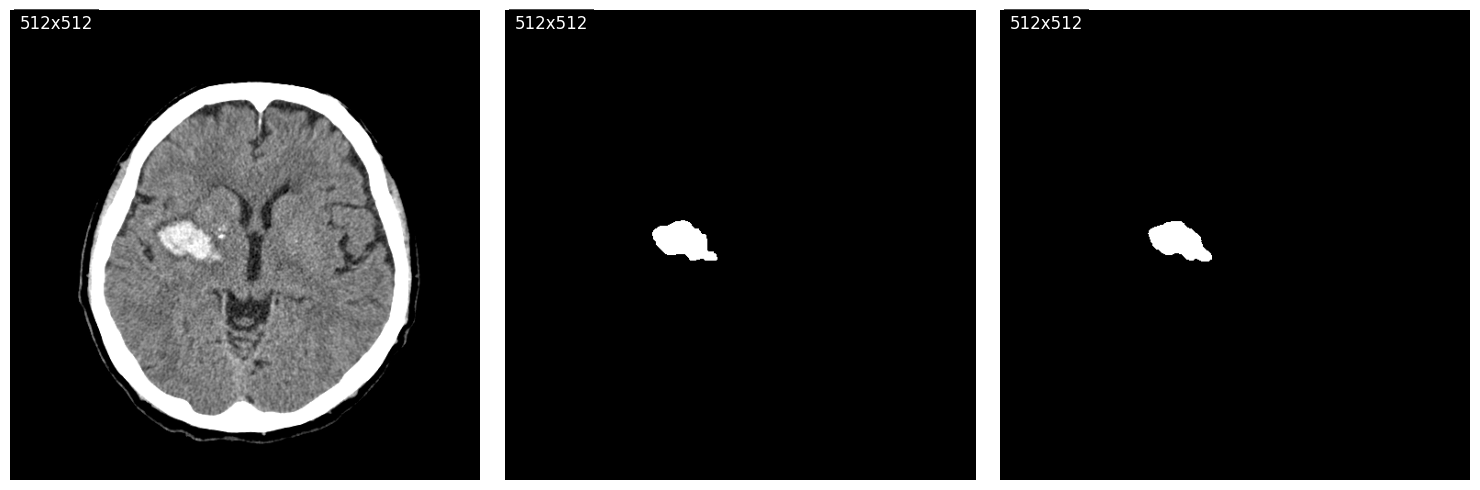

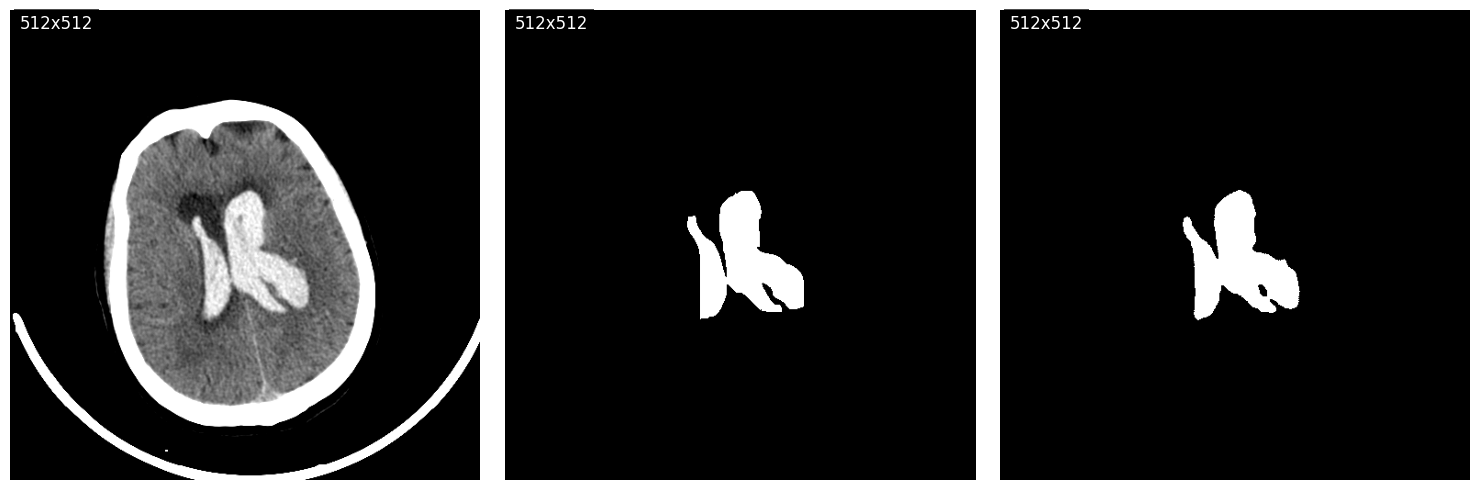

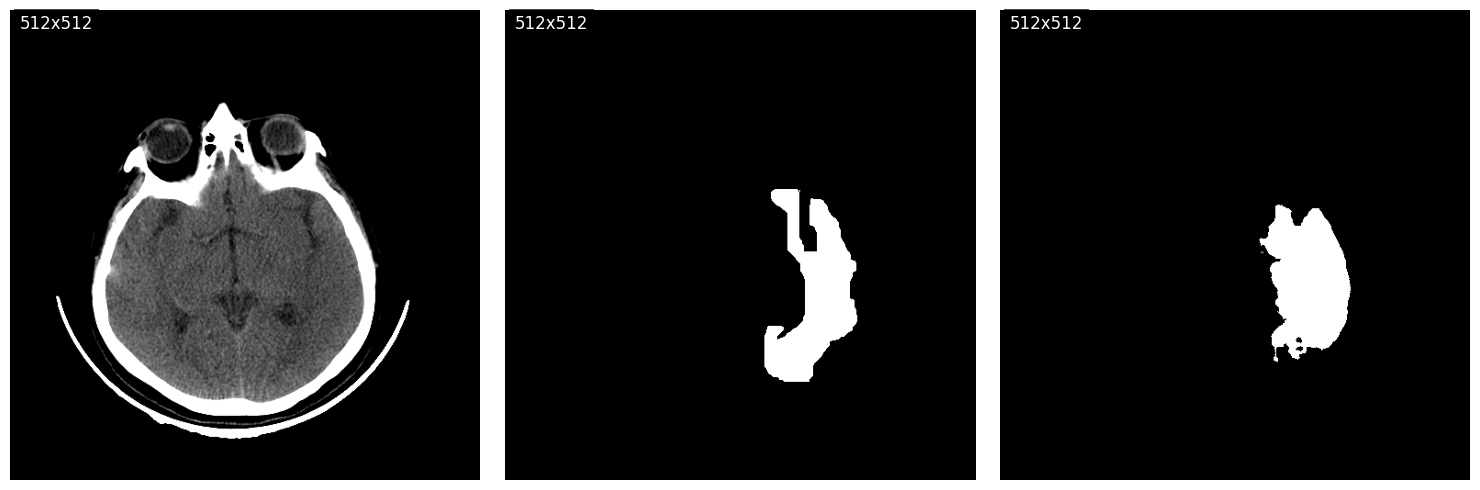

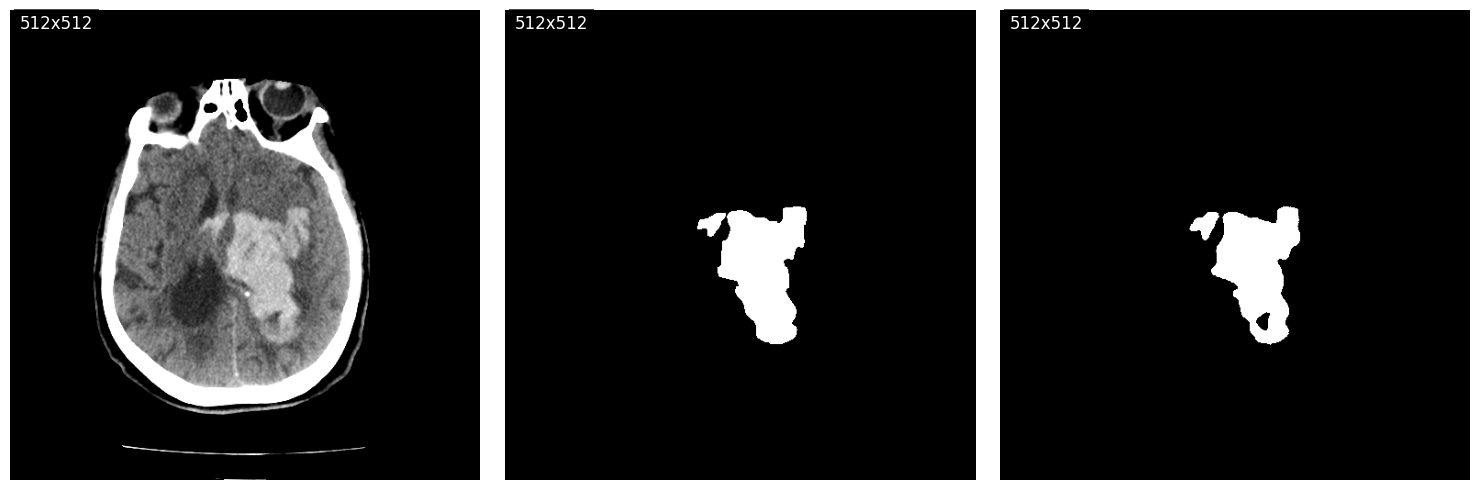

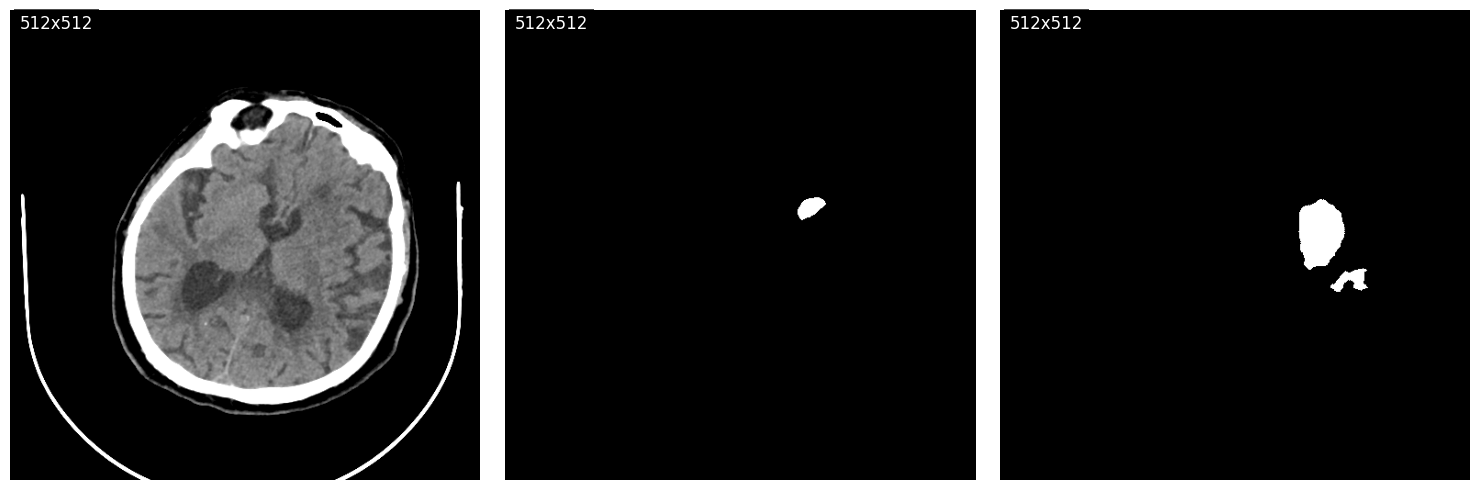

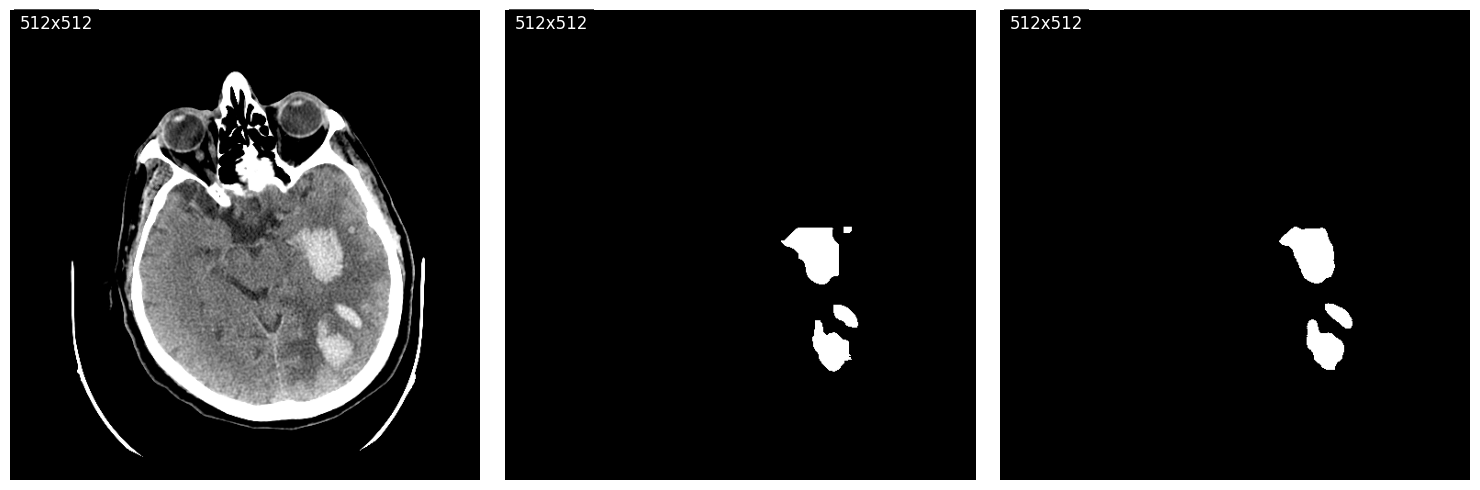

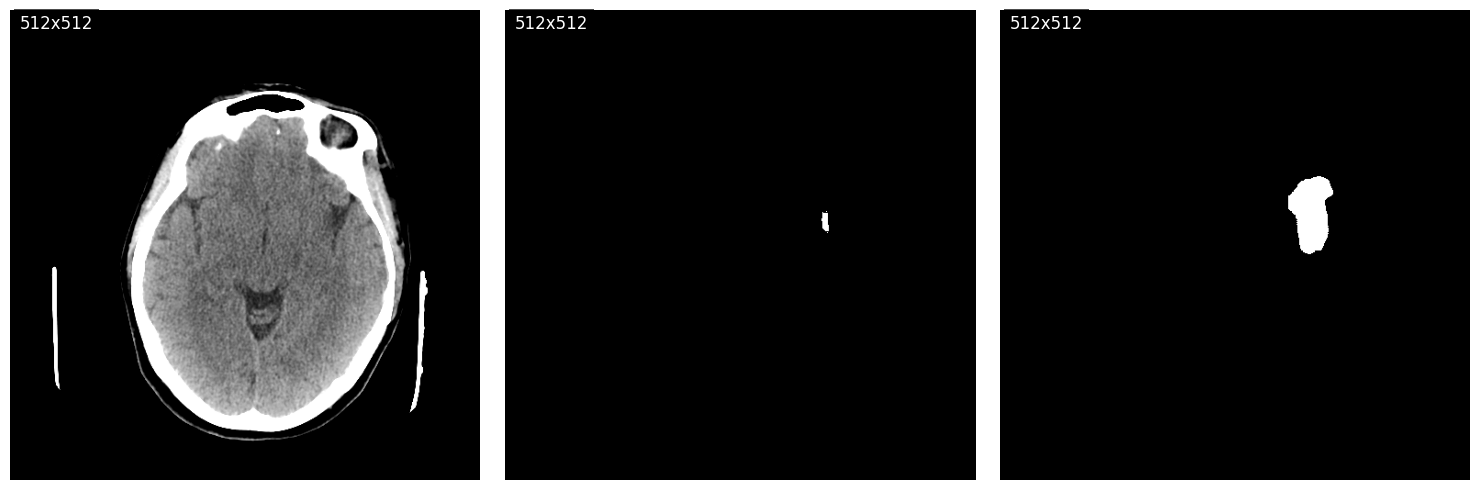

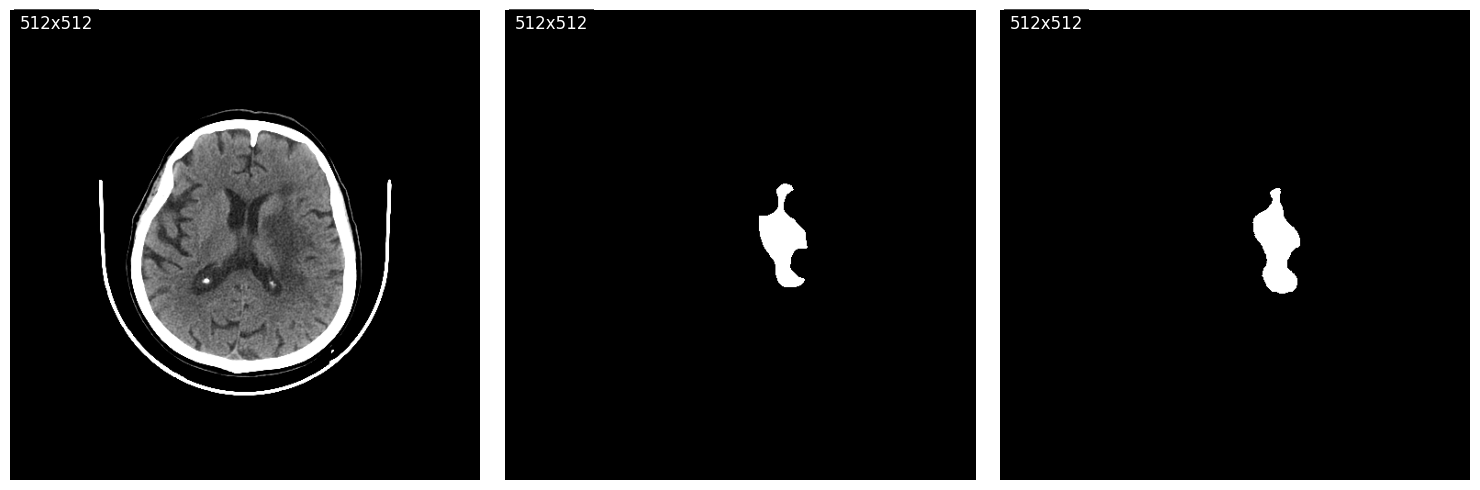

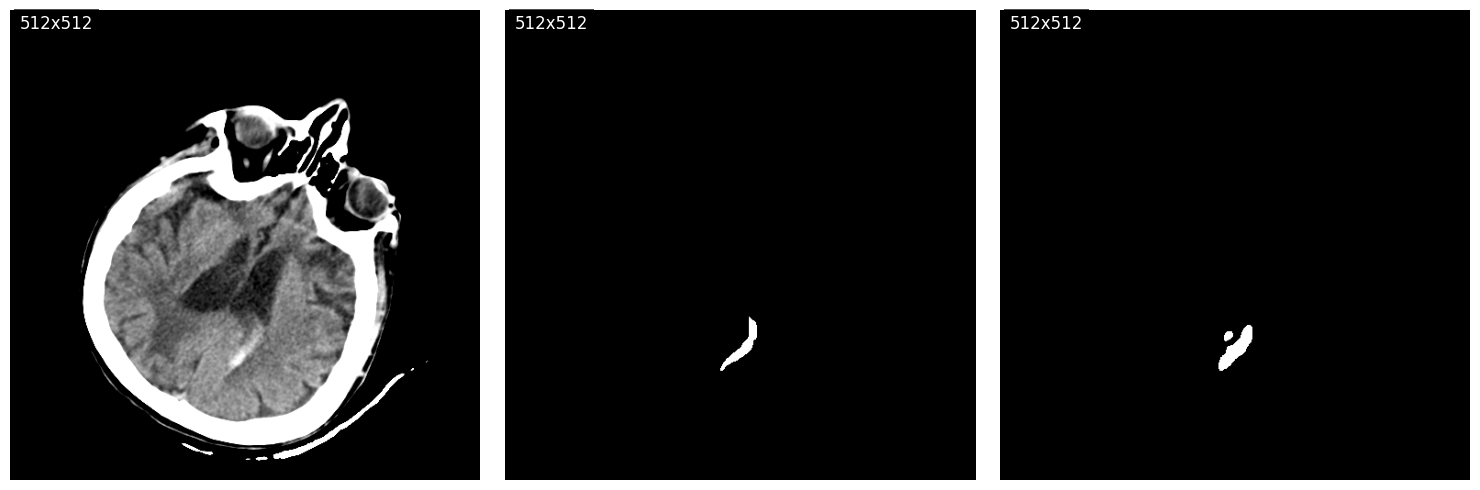

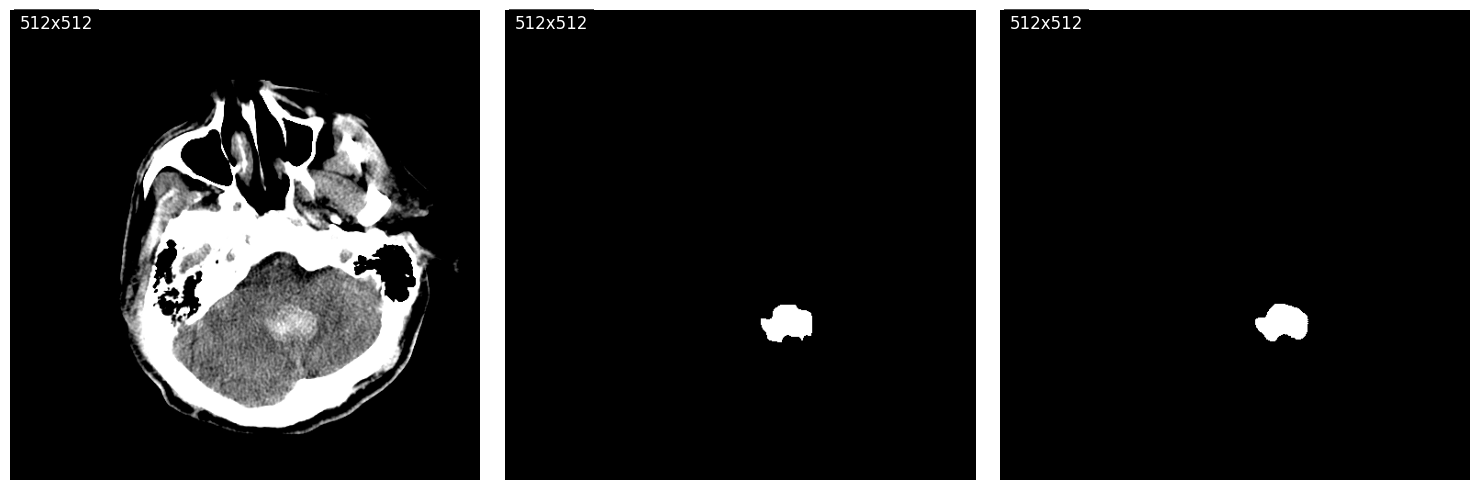

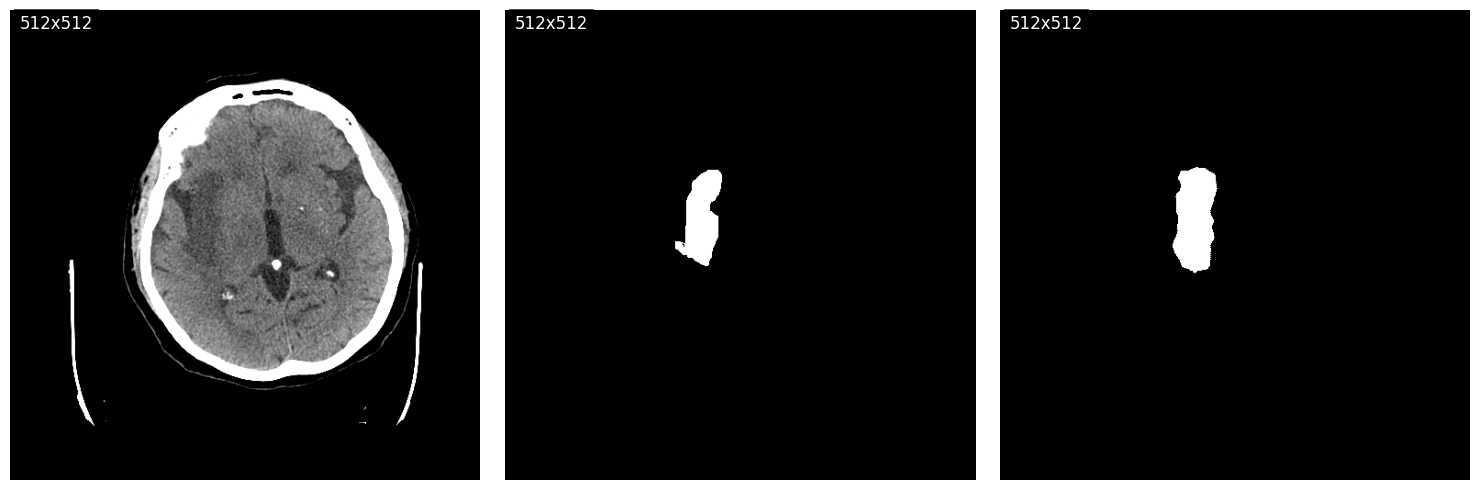

In [ ]:
num_test_images = 30  # 30 test görüntüsü gösterilecek
image_index = 0

for test_data in test_loader:
    if image_index >= num_test_images:
        break

    test_images, test_labels = test_data[0].to(device), test_data[1].to(device)
    test_outputs1 = sliding_window_inference(test_images, roi_size, sw_batch_size, model)
    test_outputs2 = [post_trans(i) for i in decollate_batch(test_outputs1)]
    goster([test_images[0][0].cpu().detach().numpy(), test_labels[0][0].cpu().detach().numpy(),test_outputs2[0][0].cpu().detach().numpy()])

    image_index += 1
